# GPyOpt: configuring Scikit-learn methods

### Written by Javier Gonzalez and Zhenwen Dai, University of Sheffield.

*Last updated Tuesday, 15 March 2016.*

The goal of this notebook is to use GPyOpt to tune the parameters of Machine Learning algorithms. In particular, we will shows how to tune the hyper-parameters for the [Support Vector Regression (SVR)](http://www.svms.org/regression/SmSc98.pdf) implemented in [Scikit-learn](http://scikit-learn.org/stable/). Given the standard interface of Scikit-learn, other models can be tuned in a similar fashion. 

We start loading the requires modules.

In [17]:
%pylab inline  
import GPy
import GPyOpt
import numpy as np
from sklearn import svm
from numpy.random import seed
seed(12345)

Populating the interactive namespace from numpy and matplotlib


For this example we will use the Olympic marathon dataset available in GPy. 
We split the original dataset into the training data (first 20 data points) and testing data (last 7 data points). The performance of SVR is evaluated in terms of Rooted Mean Squared Error (RMSE) on the testing data.

In [18]:
# Let's load the dataset
GPy.util.datasets.authorize_download = lambda x: True # prevents requesting authorization for download.
data = GPy.util.datasets.olympic_marathon_men()
X = data['X']
Y = data['Y']
X_train = X[:20]
Y_train = Y[:20,0]
X_test = X[20:]
Y_test = Y[20:,0]

Let's first see the results with the default kernel parameters.

In [50]:
from sklearn import svm
svr = svm.SVR()
svr.fit(X_train,Y_train)
Y_train_pred = svr.predict(X_train)
Y_test_pred = svr.predict(X_test)
print("The default parameters obtained: C="+str(svr.C)+", epilson="+str(svr.epsilon)+", gamma="+str(svr.gamma))

The default parameters obtained: C=1.0, epilson=0.1, gamma=auto


We compute the RMSE on the testing data and plot the prediction. With the default parameters, SVR does not give an OK fit to the training data but completely miss out the testing data well.

RMSE = 0.56330740612


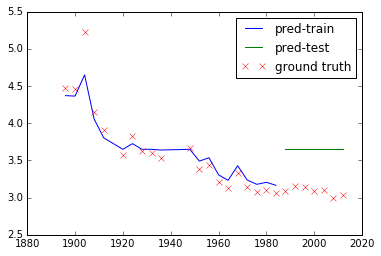

In [51]:
plot(X_train,Y_train_pred,'b',label='pred-train')
plot(X_test,Y_test_pred,'g',label='pred-test')
plot(X_train,Y_train,'rx',label='ground truth')
plot(X_test,Y_test,'rx')
legend(loc='best')
print("RMSE = "+str(np.sqrt(np.square(Y_test_pred-Y_test).mean())))

Now let's try Bayesian Optimization. We first write a wrap function for fitting with SVR. The objective is the RMSE from cross-validation. We optimize the parameters in *log* space.

In [40]:
nfold = 3
def fit_svr_val(x):
    x = np.atleast_2d(np.exp(x))
    fs = np.zeros((x.shape[0],1))
    for i in range(x.shape[0]):
        fs[i] = 0
        for n in range(nfold):
            idx = np.array(range(X_train.shape[0]))
            idx_valid = np.logical_and(idx>=X_train.shape[0]/nfold*n, idx<X_train.shape[0]/nfold*(n+1))
            idx_train = np.logical_not(idx_valid)
            svr = svm.SVR(C=x[i,0], epsilon=x[i,1],gamma=x[i,2])
            svr.fit(X_train[idx_train],Y_train[idx_train])
            fs[i] += np.sqrt(np.square(svr.predict(X_train[idx_valid])-Y_train[idx_valid]).mean())
        fs[i] *= 1./nfold
    return fs

## -- Note that similar wrapper functions can be used to tune other Scikit-learn methods

We set the search interval of $C$ to be roughly $[0,1000]$ and the search interval of $\epsilon$ and $\gamma$ to be roughtly $[1\times 10^{-5},0.1]$.

In [41]:
domain       =[{'name': 'C',      'type': 'continuous', 'domain': (0.,7.)},
               {'name': 'epsilon','type': 'continuous', 'domain': (-12.,-2.)},
               {'name': 'gamma',  'type': 'continuous', 'domain': (-12.,-2.)}]

We, then, create the GPyOpt object and run the optimization procedure. It might take a while.

In [46]:
opt = GPyOpt.methods.BayesianOptimization(f = fit_svr_val,            # function to optimize       
                                          domain = domain,         # box-constrains of the problem
                                          acquisition_type ='LCB',       # LCB acquisition
                                          acquisition_weight = 0.1)   # Exploration exploitation

LBC acquisition does now make sense with cost. Cost set to constant.
** GPyOpt Bayesian Optimization class initialized succesfuly **


   ** Maximum number of iterations reached **


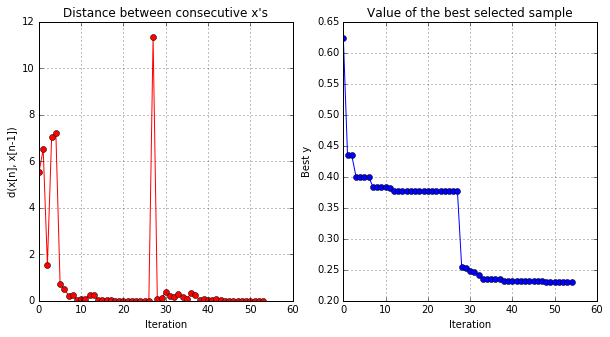

In [47]:
# it may take a few seconds
opt.run_optimization(max_iter=50)
opt.plot_convergence()

Let's show the best parameters found. They differ significantly from the default parameters.

In [48]:
x_best = np.exp(opt.X[np.argmin(opt.Y)])
print("The best parameters obtained: C="+str(x_best[0])+", epilson="+str(x_best[1])+", gamma="+str(x_best[2]))
svr = svm.SVR(C=x_best[0], epsilon=x_best[1],gamma=x_best[2])
svr.fit(X_train,Y_train)
Y_train_pred = svr.predict(X_train)
Y_test_pred = svr.predict(X_test)

The best parameters obtained: C=576.474407711, epilson=0.113244782748, gamma=6.54165643567e-06


We can see SVR does a reasonable fit to the data. The result could be further improved by increasing the *max_iter*. 

RMSE = 0.0666347593662


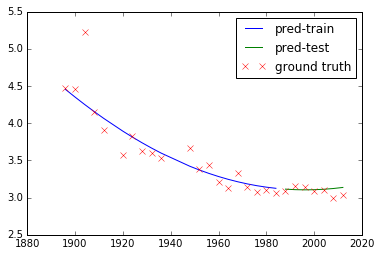

In [49]:
plot(X_train,Y_train_pred,'b',label='pred-train')
plot(X_test,Y_test_pred,'g',label='pred-test')
plot(X_train,Y_train,'rx',label='ground truth')
plot(X_test,Y_test,'rx')
legend(loc='best')
print("RMSE = "+str(np.sqrt(np.square(Y_test_pred-Y_test).mean())))